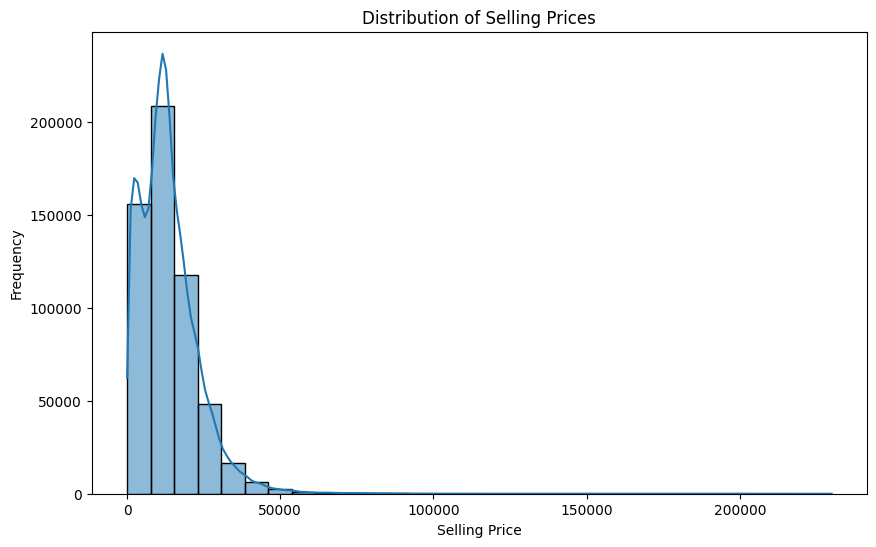

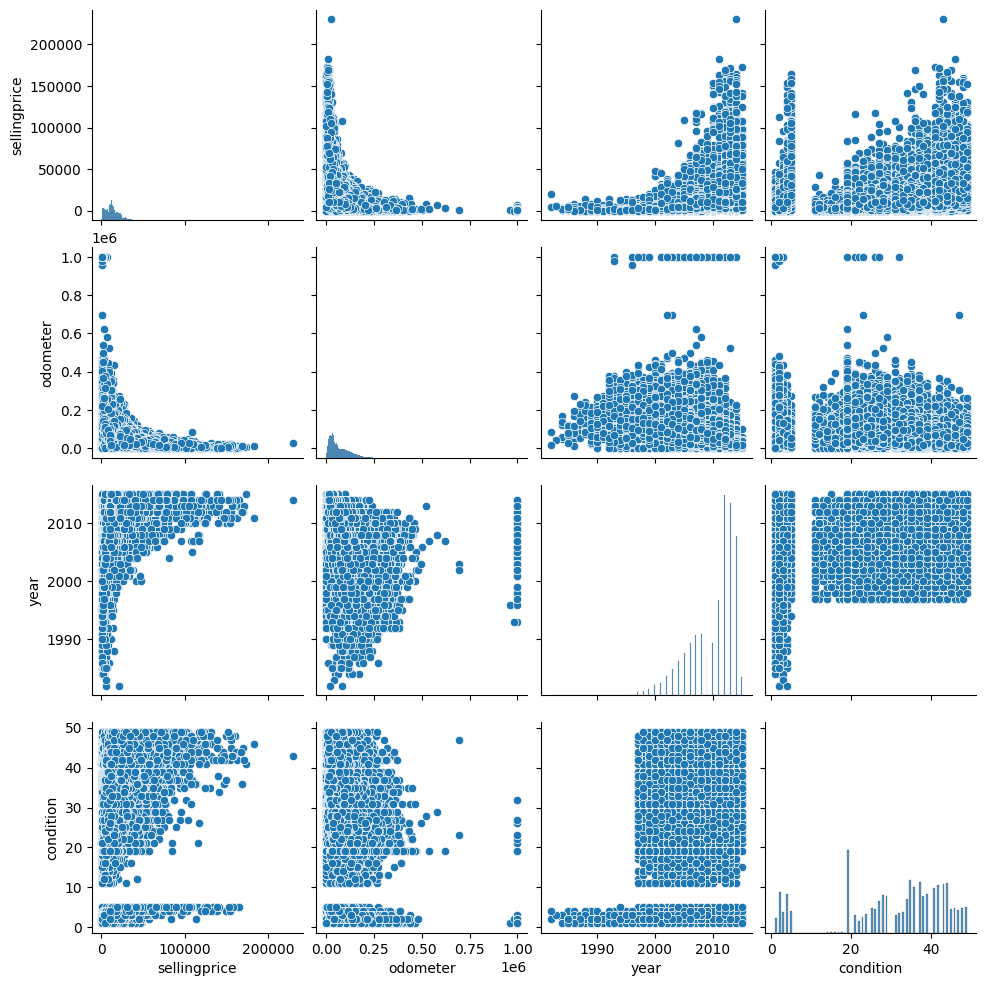

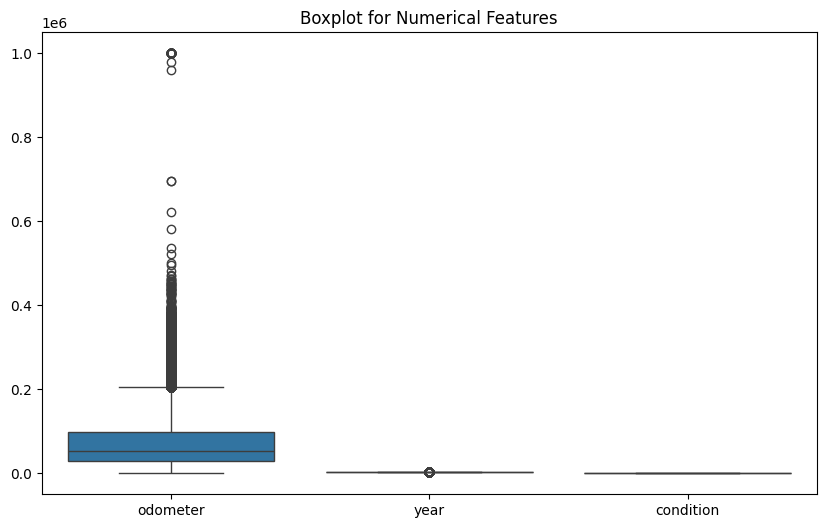

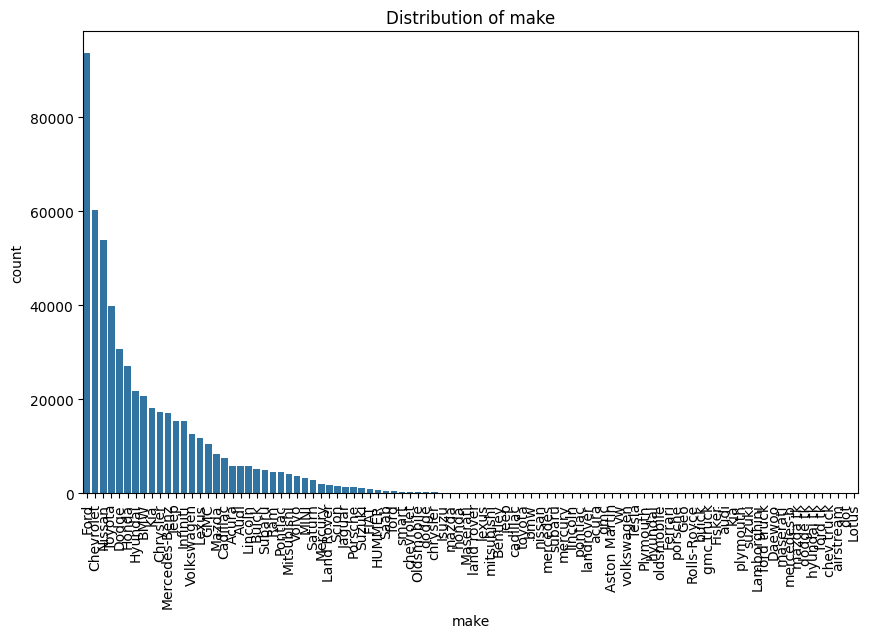

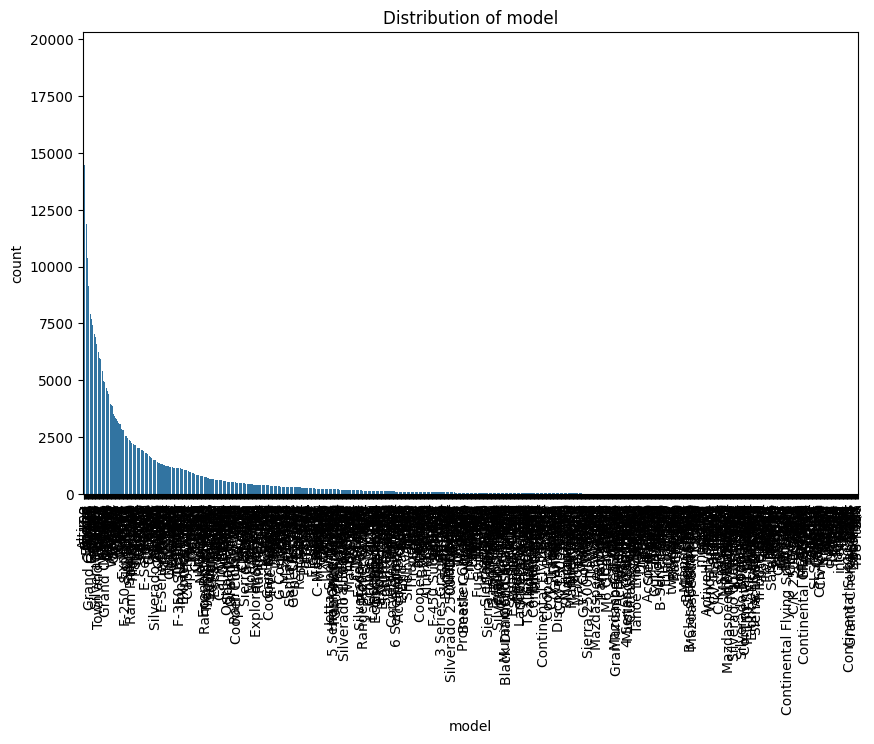

Mean Absolute Error (MAE): 2764.6858395347
Mean Squared Error (MSE): 18511689.259855345
R-squared (R2): 0.8059929286712135
Predicted Selling Price for the example car: $29193.70


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

# -----------------------------------------
# 1. Load the dataset
# -----------------------------------------
data = pd.read_csv(r"C:\Users\ivish\OneDrive\Desktop\car_prices.csv")

# -----------------------------------------
# 2. Data Visualization
# -----------------------------------------

# 2.1 Visualize the distribution of the target variable (selling price)
plt.figure(figsize=(10, 6))
sns.histplot(data['sellingprice'], bins=30, kde=True)
plt.title('Distribution of Selling Prices')
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.show()

'''# 2.2 Correlation heatmap (numerical columns)
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()  '''

# 2.3 Pairplot for visualizing relationships between numerical features and the target
sns.pairplot(data[['sellingprice', 'odometer', 'year', 'condition']])
plt.show()

# 2.4 Boxplot to check for outliers in numerical features
plt.figure(figsize=(10, 6))
sns.boxplot(data=data[['odometer', 'year', 'condition']])
plt.title('Boxplot for Numerical Features')
plt.show()

# 2.5 Bar chart for categorical feature distributions
categorical_cols = ['make', 'model']
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(x=col, data=data, order=data[col].value_counts().index)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=90)
    plt.show()

# -----------------------------------------
# 3. Data Cleaning: Handling missing values
# -----------------------------------------

# Drop rows where 'sellingprice' (the target) is NaN
data = data.dropna(subset=['sellingprice'])

# Define categorical and numerical columns
categorical_cols = ['make', 'model']
numeric_cols = ['odometer', 'condition', 'year']

# -----------------------------------------
# 4. Feature Engineering and Preprocessing
# -----------------------------------------

# Split the data into features (X) and target (y)
X = data.drop(columns='sellingprice')
y = data['sellingprice']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a preprocessing pipeline including imputation
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),  # Impute missing numerical values
            ('scaler', StandardScaler())
        ]), numeric_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical values
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

# -----------------------------------------
# 5. Model Building, Training, and Hyperparameter Tuning
# -----------------------------------------

# Define the pipeline with the preprocessor and Linear Regression model
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

# Hyperparameter tuning with GridSearchCV
param_grid = {'model__fit_intercept': [True, False]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best model from GridSearchCV
best_model = grid_search.best_estimator_

# -----------------------------------------
# 6. Model Evaluation on Test Set
# -----------------------------------------

# Make predictions
y_pred = best_model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Display evaluation metrics
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared (R2): {r2}')

# -----------------------------------------
# 7. Model Saving for Deployment
# -----------------------------------------

# Save the best model to a file
joblib.dump(best_model, 'car_price_prediction_model_cleaned.pkl')

# -----------------------------------------
# 8. Example Prediction
# -----------------------------------------

# Example car features
example_car = pd.DataFrame({
    'year': [2018],
    'make': ['BMW'],
    'model': ['3 Series'],
    'odometer': [25000],
    'condition': [40]
})

# Predict the selling price for the example car
loaded_model = joblib.load('car_price_prediction_model_cleaned.pkl')
predicted_price = loaded_model.predict(example_car)

print(f'Predicted Selling Price for the example car: ${predicted_price[0]:.2f}')
